# The calibration method of $M/PH/N/1 \longrightarrow  \ldots \longrightarrow ./PH/N/1$ queueing model with NS-3 simulation

This experiment consists of a calibration method of queueing model. We consider a tandem model of a wireless network with  𝑀/𝑃𝐻/𝑁/1⟶…⟶./𝑃𝐻/𝑁/1  nodes. The exponential distribution is used to model an arrival distribution. A service time distribution is obtained by PH fitting methods. Approximation of a service time distribution is implemented with Network Simulation 3 NS-3. We researched IEEE 802.11n wireless broadband network.

Queueing model is built with the simulation model of Open Source project in Python `https://github.com/ipu69/pyqumo`.

In [100]:
import json
from dataclasses import dataclass

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import patches
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from tabulate import tabulate
from sklearn.metrics import max_error, mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error 

from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.fitting.acph2 import fit_acph2
from pyqumo.stats import get_cv, get_skewness, get_noncentral_m2
from pyqumo.stats import get_noncentral_m3

from pyqumo.random import HyperErlang, Exponential
from pyqumo.cqumo.sim import simulate_tandem

## Loading of datasets from NS-3 model.

In our study, we consider a wireless broadband network with 3 base stations and a gateway. All packets are forwarded from the first station through the station system $S_1 \rightarrow S_2 \rightarrow S_3$ to the gateway $S_g$. 

The base station has the following technical parameters:
* protocol 802.11n;
* MAC layer's buffer size is equal to 500 (default value).
* (and also some characteristics).

NS-3 generated 1 000 000 packets. We collected three data samples. They are response times between sta $S_1$ and sta $S_2$, response times between sta $S_2$ and sta $S_3$, and response times between sta $S_4$ and gateway $S_g$. Also, we piled up a network end-to-delay that is equal to an average time spent by packets on the network.

`JSON-files` include response times between stations in a wireless network. 

The sample size is equal to the count of generated packets. In our case, there are 1 000 000 samples in each case.

In [201]:
# ''' LOADING NS-3 DATA ''' 

CURRENT_INTENSITY = 100
PACKETS_COUNT = 500_000
link_1 = pd.read_json('./data/ns3_dataset/lambda=100_station_0.json')
link_2 = pd.read_json('./data/ns3_dataset/lambda=100_station_1.json')
link_3 = pd.read_json('./data/ns3_dataset/lambda=100_station_2.json')

# CURRENT_INTENSITY = 500
# PACKETS_COUNT = 500_000
# link_1 = pd.read_json('./data/ns3_dataset/lambda=500_station_0.json')
# link_2 = pd.read_json('./data/ns3_dataset/lambda=500_station_1.json')
# link_3 = pd.read_json('./data/ns3_dataset/lambda=500_station_2.json')

# CURRENT_INTENSITY = 1000
# PACKETS_COUNT = 300_000
# link_1 = pd.read_json('./data/ns3_dataset/lambda=1000_station_0.json')
# link_2 = pd.read_json('./data/ns3_dataset/lambda=1000_station_1.json')
# link_3 = pd.read_json('./data/ns3_dataset/lambda=1000_station_2.json')

# deb

Let's take a look at the data

In [193]:
len(link_3)

495706

In [194]:
len(link_2)

496412

In [195]:
len(link_1)

495540

In [196]:
#len(link_0)

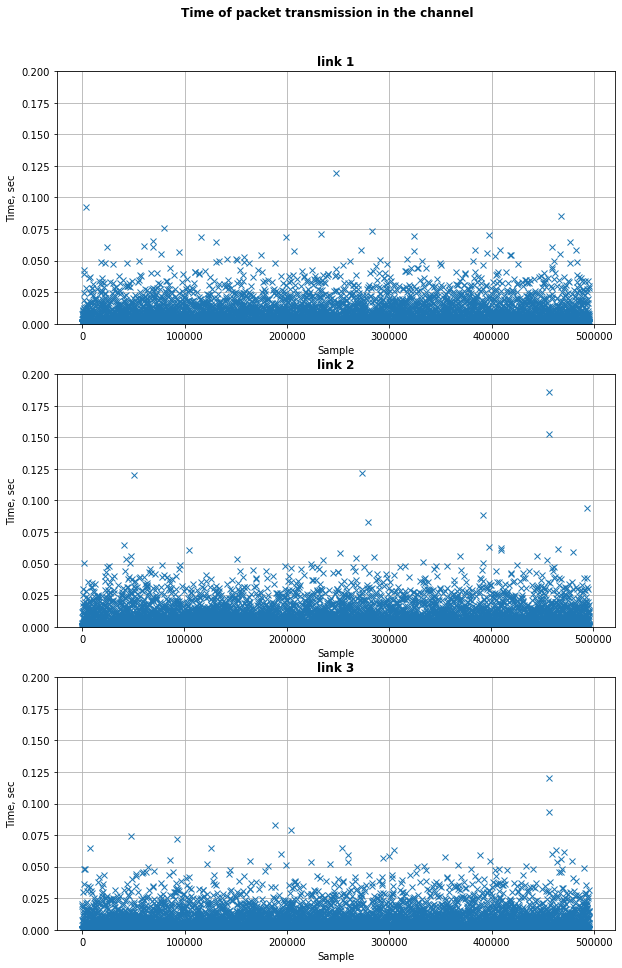

In [202]:
""" Link between stations"""
fig = plt.figure(figsize=(10, 15))
fig.suptitle('Time of packet transmission in the channel', 
             fontweight='bold')
plt.subplots_adjust(top=0.92)
label = ['link 1', 'link 2', 'link 3']
link = [link_1, link_2, link_3]

for i in range(len(label)):
    ax = fig.add_subplot(3, 1, i+1)
    plt.title(label[i], fontweight='bold')
    plt.plot(link[i], 'x')
    plt.ylim([0, 0.2])
    plt.xlabel('Sample')
    plt.ylabel('Time, sec')
    plt.grid()

## PH fitting

So, we have response time data sets. We need to fit a service time distribution. First of all, it is necessary to get the first three noncentral moments.

**So, k-th non central moment is calculated as**

\begin{equation}
\mu^{\left( k\right) }\equiv\mathbb{E}\{X^{k}\},\quad k=1,2,\ldots \,\text{,}
\end{equation}

In [203]:
def get_non_central_moment(sample: pd.DataFrame, k:int=1) -> np.float64:
    "Calculating of k-th non central moment"
    return np.mean(sample[0] ** k)

In [204]:
''' 
Dataclass of commincation link. 
It is consists NS-3 data and 
1st, 2nd, and 3rd moments
'''
@dataclass
class S2SLink:
    dataset: pd.DataFrame
    m1: float
    m2: float
    m3: float

We need to prepare service time distribution. It can be solve with PH fitting methods. In our exploration we used fitting algorithms designed by Johnson and `Mary A. Johnson & Michael R. Taaffe (1989) Matching moments to phase distributions: Mixtures of erlang distributions of common order, Communications in Statistics. Stochastic Models, 5:4, 711-743, DOI: 10.1080/15326348908807131`

In [205]:
def get_service_dist(e2e_link: dataclass) -> list:
    srv_dist = [None]*len(e2e_link)
    for i in range(len(e2e_link)):
        srv, _ = fit_mern2(moments=[e2e_link[i].m1, 
                                  e2e_link[i].m2, 
                                  e2e_link[i].m3])
        srv_dist[i] = srv
    
    return srv_dist

Let each link will be approximated especial **Phase Type distribution**:

In [206]:
s12_link = S2SLink(dataset=link_1, 
                   m1=get_non_central_moment(link_1, k=1),
                   m2=get_non_central_moment(link_1, k=2),
                   m3=get_non_central_moment(link_1, k=3))

s23_link = S2SLink(dataset=link_2, 
                   m1=get_non_central_moment(link_2, k=1),
                   m2=get_non_central_moment(link_2, k=2),
                   m3=get_non_central_moment(link_2, k=3))

s34_link = S2SLink(dataset=link_3, 
                   m1=get_non_central_moment(link_3, k=1),
                   m2=get_non_central_moment(link_3, k=2),
                   m3=get_non_central_moment(link_3, k=3))
e2e_link = [s12_link, s23_link, s34_link]

service_dist_mph1 = get_service_dist(e2e_link) 

We considered the mathematical model of tandem queueing network 𝑀/𝑃𝐻/𝑁/1⟶…⟶./𝑃𝐻/𝑁/1 to describe a wireless broadband network with linear topology. The interarrival time is described using Poisson distribution. The rate is equal to 100 packet/sec.

In [207]:
# M/PH/1 model
arr = Exponential(CURRENT_INTENSITY)
ret = simulate_tandem(arr, service_dist_mph1, 500, PACKETS_COUNT)
ret.delivery_delays

[Statistics(avg=0.0019707408734916825, var=7.608026013149745e-05, std=0.008722399906648253, count=99999),
 Statistics(avg=0.0, var=0.0, std=0.0, count=0),
 Statistics(avg=0.0, var=0.0, std=0.0, count=0)]

And also, we prepared with M/M/1/N queueuing model.

In [208]:
# M/M/1 model
arr = Exponential(CURRENT_INTENSITY)
service_dist_mm1 = [Exponential(1/s12_link.m1), 
                    Exponential(1/s23_link.m1),
                    Exponential(1/s34_link.m1)]
ret = simulate_tandem(arr, service_dist_mm1, 500, PACKETS_COUNT)
ret.delivery_delays

[Statistics(avg=0.0011302867917241262, var=1.221924436023056e-06, std=0.0011054069097047728, count=99999),
 Statistics(avg=0.0, var=0.0, std=0.0, count=0),
 Statistics(avg=0.0, var=0.0, std=0.0, count=0)]

## Queueing models estimate

In the NS-3 model we prepared `35` samples of end-to-end delays for tandem network with 3 stations `e2e_ns3_estimate`. So we need to compare output data of queueing models with NS-3 model.

In [209]:
with open(r'./data/ns3_dataset/lambda100.json', 'r') as json_file:
    res = json.load(json_file)
e2e_ns3_estimate = []
for r in res:
    e2e_ns3_estimate.append(r["e2e"])
e2e_ns3_estimate

[0.0007076,
 0.0007286,
 0.0007786,
 0.0007307,
 0.0007281,
 0.000718,
 0.0007283,
 0.0007683,
 0.00070316,
 0.00081457]

In [210]:
samples = 10
e2e_mm1 = np.zeros(samples)
e2e_mph1 = np.zeros(samples)

for i in range(samples):
    ret_mm1 = simulate_tandem(arr, service_dist_mm1, 500, PACKETS_COUNT)
    e2e_mm1[i] = ret_mm1.delivery_delays[0].avg
    
    ret_mph1 = simulate_tandem(arr, service_dist_mph1, 500, PACKETS_COUNT)
    e2e_mph1[i] = ret_mph1.delivery_delays[0].avg

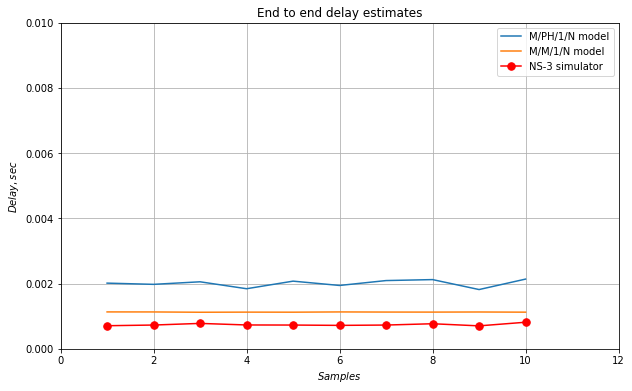

In [211]:
plt.figure(figsize=(10,6));
plt.title(f'End to end delay estimates');
plt.plot(range(1, 11), e2e_mph1, '-', label='M/PH/1/N model');
plt.plot(range(1, 11), e2e_mm1, '-', label='M/M/1/N model'); 
plt.plot(range(1, 11), e2e_ns3_estimate, '-r.', markersize=15, label='NS-3 simulator');

plt.grid();
plt.xlabel(r'$Samples$');
plt.ylabel(r'$Delay, sec$');
plt.ylim([0.00, 0.01]);
plt.xlim([0, samples + 2]);
plt.legend()

In [87]:
f'NS-3 simulator. Mean of e2e delay = {np.mean(e2e_ns3_estimate):f}'

'NS-3 simulator. Mean of e2e delay = 0.005691'

In [88]:
f'NS-3 simulator. Mean of e2e delay = {np.mean(e2e_mph1):f}'

'NS-3 simulator. Mean of e2e delay = 0.170472'

In [21]:
error = np.absolute(
    np.mean(e2e_mph1)-np.mean(e2e_ns3_estimate)
)*100/np.mean(e2e_ns3_estimate)

In [22]:
f'Relative error = {error:.2f} %'

'Relative error = 53.97 %'

In [23]:
f'Max error = {max_error(e2e_ns3_estimate, e2e_mph1) * 100:.2f} %'

'Max error = 0.86 %'

In [24]:
f'Mean squared error = {mean_squared_error(e2e_ns3_estimate, e2e_mph1):f}'

'Mean squared error = 0.000016'

## Queueing models with different length

In [25]:
with open(r'./data/ns3_dataset/lambda100_stations_count.json', 'r') as json_file:
    res = json.load(json_file)
e2e_ns3_estimate_depend_on_stations_count = []
for r in res:
    e2e_ns3_estimate_depend_on_stations_count.append(r["e2e"])
e2e_ns3_estimate_depend_on_stations_count

[0.000294288,
 0.000413796,
 0.0062362,
 0.0087554,
 0.013225,
 0.0178154,
 0.018253,
 0.0193808,
 0.0195144]

In [26]:
def simulate_m_ph_problem(stations_count, packets_count, left_link, central_link, right_link):
    arr = Exponential(CURRENT_INTENSITY)
    if stations_count == 2:
        service_dist_mph1 = get_service_dist([left_link])
        return simulate_tandem(arr, service_dist_mph1, 500, packets_count)
    if stations_count == 3:
        service_dist_mph1 = get_service_dist([left_link, central_link])
        return simulate_tandem(arr, service_dist_mph1, 500, packets_count)
    
    average = []
    
    for i in range(stations_count - 3):
        average.append(central_link)
        
    service_dist_mph1 = get_service_dist([left_link] + average + [right_link])
    return simulate_tandem(arr, service_dist_mph1, 500, packets_count)

In [27]:
def simulate_m_m_problem(stations_count, packets_count, left_link, central_link, right_link):
    arr = Exponential(CURRENT_INTENSITY)
    if stations_count == 2:
        service_dist_mm1 = [Exponential(1/left_link.m1)]
        return simulate_tandem(arr, service_dist_mm1, 500, packets_count)  
                                        
    if stations_count == 3:
        service_dist_mm1 = [Exponential(1/left_link.m1),
                            Exponential(1/central_link.m1)]
        return simulate_tandem(arr, service_dist_mm1, 500, packets_count)
    
    average = []
    
    for i in range(stations_count - 3):
        average.append(Exponential(1/central_link.m1))
                                        
    service_dist_mm1 = [Exponential(1/left_link.m1)] + average + [Exponential(1/right_link.m1)]
    return simulate_tandem(arr, service_dist_mm1, 500, packets_count)

### Tandems simulations with different tandem size

In [32]:
## links calculation
left_link = S2SLink(dataset=link_1, 
                   m1=get_non_central_moment(link_1, k=1),
                   m2=get_non_central_moment(link_1, k=2),
                   m3=get_non_central_moment(link_1, k=3))

central_link = S2SLink(dataset=link_2, 
                   m1=get_non_central_moment(link_2, k=1),
                   m2=get_non_central_moment(link_2, k=2),
                   m3=get_non_central_moment(link_2, k=3))

right_link = S2SLink(dataset=link_3, 
                   m1=get_non_central_moment(link_3, k=1),
                   m2=get_non_central_moment(link_3, k=2),
                   m3=get_non_central_moment(link_3, k=3))

e2e_mm1 = []
e2e_mph1 = []

# stations count from 2 to 10
for stations_count in range(2, 11):
    ret_mm1 = simulate_m_m_problem(stations_count, 1_000_000, left_link, central_link, right_link)
    e2e_mm1.append(ret_mm1.delivery_delays[0].avg)
    
    ret_mph1 = simulate_m_ph_problem(stations_count, 1_000_000, left_link, central_link, right_link)
    e2e_mph1.append(ret_mph1.delivery_delays[0].avg)
    


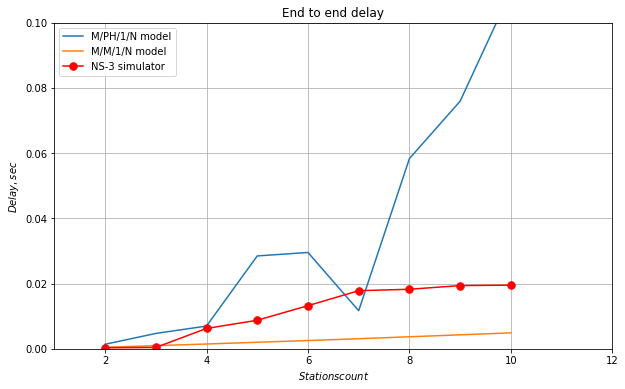

In [33]:
plt.figure(figsize=(10,6));
plt.title(f'End to end delay');
plt.plot(range(2, 11), e2e_mph1, '-', label='M/PH/1/N model');
plt.plot(range(2, 11), e2e_mm1, '-', label='M/M/1/N model'); 
plt.plot(range(2, 11), e2e_ns3_estimate_depend_on_stations_count, '-r.', markersize=15, label='NS-3 simulator');

plt.grid();
plt.xlabel(r'$Stations count$');
plt.ylabel(r'$Delay, sec$');
plt.ylim([0, 0.1]);
plt.xlim([1, 12]);
plt.legend()